# Abobe GenSolve Hackathon
## Problem Statement
Our mission is to identify, regularize, and beautify curves in 2D Euclidean
space. We’ll start by focusing on closed curves and progressively work with more complex shapes. This project will also cover symmetry and curve completion techniques.


In [2]:
# Import necessary libraries
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install pillow
%pip install opencv-python
%pip install cairosvg
%pip install svgwrite
%pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 2.1 MB/s eta 0:00:00


# Libraries Used
- **OpenCV**: OpenCV is a library of programming functions mainly aimed at real-time computer vision.
- **Numpy**: NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.
- **Matplotlib**: Matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy.
- **Scipy**: SciPy is a free and open-source Python library used for scientific and technical computing. SciPy contains modules for optimization, linear algebra, integration, interpolation, special functions, FFT, signal and image processing, ODE solvers and other tasks common in science and engineering.
- **PIL** (pillow): The Python Imaging Library (PIL) adds image processing capabilities to your Python interpreter. This library supports many file formats, and provides powerful image processing and graphics capabilities.
- **Pandas**: Pandas is a fast, powerful, flexible and easy to use open source data analysis and data manipulation library built on top of the Python programming language.
- **cv2**: OpenCV-Python is a library of Python bindings designed to solve computer vision problems.
- **cairosvg**: CairoSVG is a SVG converter based on Cairo. It can export SVG files to PDF, PostScript and PNG files.
- **svgwrite**: svgwrite is a Python module that creates SVG drawings.

In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import cv2
from scipy.interpolate import UnivariateSpline, interp1d
import matplotlib.pyplot as plt
import svgwrite
import zipfile
import cairosvg

In [5]:
# Unzip the dataset
with zipfile.ZipFile("problems.zip","r") as zip_ref:
    zip_ref.extractall() # problems folder will be created

!mkdir solutions

mkdir: cannot create directory ‘solutions’: File exists


In [6]:
# Utility functions

def read_csv(csv_path):
    """
    CSV Data Loading and Processing
    """
    np_path_XYs = np.genfromtxt(csv_path ,delimiter = ',')
    path_XYs = []
    for i in np.unique(np_path_XYs [: , 0]):
        npXYs = np_path_XYs[np_path_XYs[: , 0] == i ][: , 1:]
        XYs = []
        for j in np.unique(npXYs[: , 0]):
            XY = npXYs[npXYs[: , 0] == j ][: , 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot(paths_XYs):
    """Plotting the Curves"""
    fig , ax = plt.subplots(tight_layout = True ,figsize =(8 , 8))
    for i , XYs in enumerate(paths_XYs):
        # c = colours [ i % len( colours )]
        for XY in XYs:
            ax.plot(XY[: , 0] ,XY[: , 1] ,linewidth =2)
    ax.set_aspect("equal")
    plt.show()

### Converting Polylines to SVG
The `polylines2svg` function takes the path data and converts it into an SVG file, which is later converted to a PNG file using `cairosvg`.

In [7]:
def polylines2svg(paths_XYs, svg_path):
    """Converting Polylines to SVG"""
    W, H = 0, 0
    for path_XYs in paths_XYs:
        for XY in path_XYs:
            W, H = max(W, np.max(XY[:, 0])), max(H, np.max(XY[:, 1]))
    padding = 0.1
    W, H = int(W + padding * W), int(H + padding * H)

    dwg = svgwrite.Drawing(svg_path, profile="tiny", shape_rendering="crispEdges")
    group = dwg.g()
    colors = ["red", "blue", "green", "yellow", "purple", "orange", "cyan", "magenta"]

    for i, path in enumerate(paths_XYs):
        path_data = []
        for XY in path:
            path_data.append("M {} {}".format(XY[0, 0], XY[0, 1]))
            for j in range(1, len(XY)):
                path_data.append("L {} {}".format(XY[j, 0], XY[j, 1]))
            if not np.allclose(XY[0], XY[-1]):
                path_data.append("Z")
        c = colors[i % len(colors)]
        group.add(dwg.path(d=" ".join(path_data), fill=c, stroke="none", stroke_width=2))

    dwg.add(group)
    dwg.save()

    png_path = svg_path.replace('.svg', '.png')
    fact = 1
    if min(H, W) != 0:
        fact = max(1, 1024 // min(H, W))

### Data Smoothing and Interpolation
Here, we define functions to smooth and interpolate the points using `UnivariateSpline` and `interp1d`.

In [8]:
def smooth_points(x, y, s=0):
    """Smoothing function"""
    spline_x = UnivariateSpline(range(len(x)), x, s=s)
    spline_y = UnivariateSpline(range(len(y)), y, s=s)
    return spline_x(range(len(x))), spline_y(range(len(y)))

def interpolate_points(x, y, num_points):
    """Interpolation function"""
    t = np.linspace(0, 1, len(x))
    f_x = interp1d(t, x, kind="linear")
    f_y = interp1d(t, y, kind="linear")
    t_new = np.linspace(0, 1, num_points)
    return f_x(t_new), f_y(t_new)

### Converting Points to an Image
The points_to_image function converts the smoothed and interpolated points into a binary image.

In [9]:
def points_to_image(points, width=1000, height=1000):
    """Converting points to image"""
    img = np.zeros((height, width), dtype=np.uint8)
    for x, y in points:
        if 0 <= int(y) < height and 0 <= int(x) < width:
            img[int(y), int(x)] = 255
    return img


## Overview of Canny Edge Detection

The Canny edge detection algorithm, developed by John F. Canny in 1986, is one of the most commonly used techniques for detecting edges in images. It identifies points where the intensity of brightness changes sharply, indicating the presence of an edge or contour.

## Steps in Canny Edge Detection

1. **Noise Reduction:**  The first step involves removing noise from the image using a Gaussian filter. This helps prevent false edges caused by noise.

2. **Gradient Calculation:** The algorithm calculates the gradient intensity and direction for each pixel using methods like the Sobel operator. This step highlights regions with high spatial derivatives, which typically correspond to edges.

3. **Non-Maximum Suppression:** This step refines the edges by keeping only the local maxima of the gradient magnitude. It removes pixels that are not part of the most significant edges.

4. **Double Thresholding:** Two thresholds (high and low) are applied to filter edges. Pixels with gradient values above the high threshold are considered strong edges, while those between the two thresholds are weak edges. Pixels below the low threshold are discarded.

5. **Edge Tracking by Hysteresis:** The final step connects weak edges to strong edges. Weak edges connected to strong edges are retained, ensuring continuous and meaningful contours.

## Application in Contour Detection

Canny edge detection is highly effective for contour detection, which involves outlining the boundaries of objects in an image. Accurate edge detection enables object recognition, image segmentation, and shape analysis.

## Advantages of Canny Contours

- **Precision:** Detects true edges while minimizing false positives.
- **Noise Robustness:** The initial noise reduction helps reduce the impact of noise on edge detection.
- **Edge Connectivity:** Hysteresis ensures that edges form continuous contours, important for clear boundary definitions.


### Shape Detection
This section involves detecting shapes in the generated binary image using contours and Hough Line Transform.

Here’s the explanation in markdown format:

---

### **`detect_shapes(img)` Function Explanation**

The `detect_shapes(img)` function uses two key techniques to detect and classify shapes in an image: **Contours** and the **Hough Line Transform**.

#### **Contours:**
- **Contour Detection**: Contours are curves that join continuous points along a boundary with the same intensity. The function uses the `cv2.findContours()` method to detect these contours, identifying the edges of shapes in the image.
- **Contour Approximation**: Once contours are detected, they are approximated to simpler polygonal shapes using the `cv2.approxPolyDP()` method. This simplification helps in classifying the shapes by reducing the number of points in the contour.
- **Shape Classification**: Based on the number of vertices in the approximated contour:
  - **3 vertices**: Classified as a **Triangle**.
  - **4 vertices**: Classified as a **Square** or **Rectangle** (depending on the aspect ratio).
  - **More than 4 vertices**: Further analyzed for classification as a **Circle**, **Ellipse**, **Star**, or a general **Polygon**.

#### **Hough Line Transform:**
- **Line Detection**: The function applies the Probabilistic Hough Line Transform (`cv2.HoughLinesP()`) to detect straight lines in the image.
- **How It Works**: This technique maps edge points into a parameter space where lines are represented as peaks. If a significant number of edge points align to form a line, that line is detected and recorded.
- **Application**: Detected lines are added to the `shapes` list as a recognized shape type **"Line"**, along with the coordinates of the line’s endpoints.

### **Summary**:
- **Contours** are used to detect and classify more complex shapes (like polygons, circles, etc.), while the **Hough Line Transform** specifically detects straight lines. Both methods are crucial in identifying and differentiating between various geometric shapes within the image.

---

In [10]:
def detect_shapes(img):
    """Detecting shapes in an image"""
    shapes = []
    edges = cv2.Canny(img.copy(), 0, 50)
    edges_line = cv2.GaussianBlur(edges.copy(), (15, 15), 0)

    # Detect lines using Probabilistic Hough Line Transform
    lines = cv2.HoughLinesP(edges_line, 1, np.pi / 2, threshold=200, minLineLength=0, maxLineGap=100)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                shapes.append(("Line", np.array([[x1, y1], [x2, y2]])))

    edges = img.copy()
    # Find contours
    contours, hierarchy = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) < 500:  # Adjust the threshold as needed
            continue

        epsilon = 0.03 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # If shape is a triangle
        if len(approx) == 3:
            shapes.append(("Triangle", approx))
        elif len(approx) == 4:
            (x, y, w, h) = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            shape = "Square" if 0.85 <= aspect_ratio <= 1.15 else "Rectangle"
            shapes.append((shape, approx))
        elif len(approx) > 4:
            area = cv2.contourArea(contour)
            (x, y), radius = cv2.minEnclosingCircle(contour)
            circularity = area / (np.pi * radius * radius)
            if 0.75 <= circularity <= 1.25:
                center = (int(x), int(y))
                radius = int(radius)
                shapes.append(("Circle", (center, radius)))
            else:
                shapes.append(("Polygon", approx))

            if len(approx) >= 6:
                ellipse = cv2.fitEllipse(contour)
                center, axes, angle = ellipse
                axes = (int(axes[0] / 2), int(axes[1] / 2))
                ellipse_contour = cv2.ellipse2Poly(
                    center=(int(center[0]), int(center[1])),
                    axes=axes,
                    angle=int(angle),
                    arcStart=0,
                    arcEnd=360,
                    delta=2
                )
                ellipse_contour = np.array(ellipse_contour)
                distance = cv2.pointPolygonTest(ellipse_contour, center, True)
                if abs(distance) < 40:
                    shapes.append(("Ellipse", ellipse_contour))
            # If shape is star
            if len(approx) >= 10:
                shapes.append(("Star", approx))

    # Select the shape with the highest probability
    shape_priorities = {
        "Circle": 1,
        "Square": 2,
        "Rectangle": 3,
        "Triangle": 4,
        "Star": 5,
        "Polygon": 6,
        "Ellipse": 7,
        "Line": 8,
    }

    if shapes:
        shapes = sorted(shapes, key=lambda s: shape_priorities.get(s[0], 9))
        most_probable_shape = shapes[0]
        return [most_probable_shape]

    return shapes


### Drawing Detected Shapes on an Image
The draw_shapes function overlays the detected shapes onto the original image.

In [11]:
def draw_shapes(img, shapes, curve_points=None):
    if len(img.shape) == 2:
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    else:
        img_color = img.copy()

    blank_image = np.zeros_like(img_color)

    if shapes:
        for shape, contour in shapes:
            color = (255, 255, 255)  # White

            if shape == "Circle":
                center, radius = contour
                cv2.circle(blank_image, center, radius, color, 1)
            else:
                cv2.drawContours(blank_image, [contour], -1, color, 1)
    else:
        if curve_points is not None:
            color = (255, 255, 255)  # White
            cv2.polylines(blank_image, [curve_points], isClosed=False, color=color, thickness=1)

    return blank_image


### Combining All Images
Finally, the combine_images function merges all processed images into a single large image.

In [12]:
def combine_images(images, positions, width=1000, height=1000):
    combined_image = np.zeros((height, width, 3), dtype=np.uint8)
    for img, (x, y) in zip(images, positions):
        h, w = img.shape[:2]
        x = max(0, min(x, width - w))
        y = max(0, min(y, height - h))
        mask = img != 0
        combined_image[y : y + h, x : x + w][mask] = img[mask]
    return combined_image

### Processing the Curves and Detecting Shapes
This section processes each curve, detects shapes, and combines the results into a single image.

> Final main Function execution

## Works for both isolation and fragmentation images.
Just enter the filename present in problems folder.

In [15]:

!mkdir temp

Enter filename along without svg extensionfrag1
mkdir: cannot create directory ‘temp’: File exists


Enter filename along without svg extensionisolated


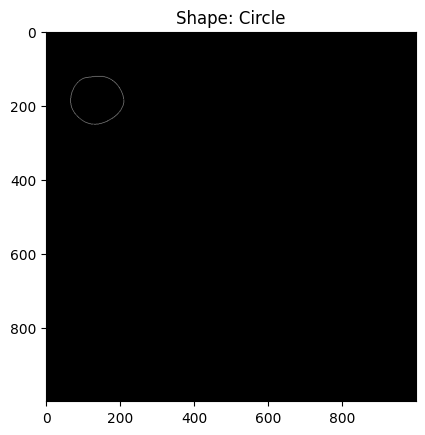

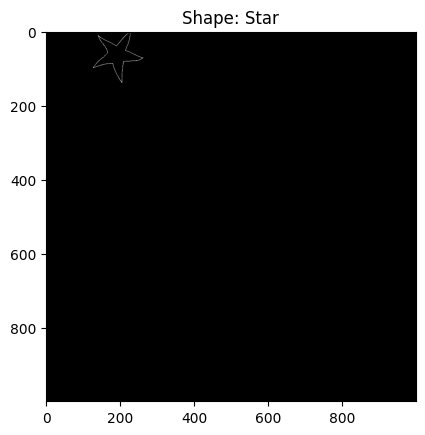

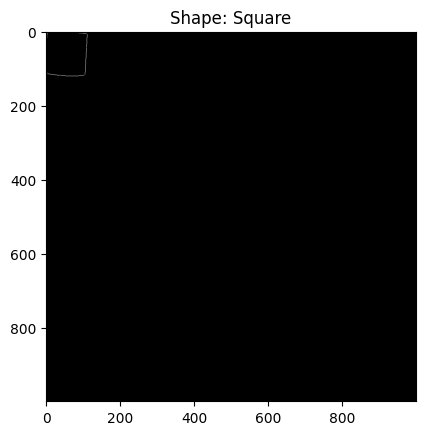

True

In [20]:
# Process each curve
filename = input("Enter filename along without svg extension")
processed_curves = []
images = []
positions = []

# Load data into a DataFrame
df = pd.read_csv(f"problems/{filename}.csv", header=None, names=["Curve", "Shape", "X", "Y"])

# Group by curve
curves = df.groupby(["Curve", "Shape"])

from cairosvg import svg2png
svg2png(url=f"problems/{filename}.svg",write_to=f"temp/{filename}.png")


for curve_id, group in curves:

    x, y = group['X'].values, group['Y'].values
    x_smooth, y_smooth = smooth_points(x, y, s=0)
    x_interp, y_interp = interpolate_points(x_smooth, y_smooth, num_points=1000)


    points = np.vstack((x_interp, y_interp)).T
    positions.append(
        (int(x.min()), int(y.min()))
    )  # Store original positions for combining

    img = points_to_image(points)
    # cv2.imwrite(f"without_shapes_detected_{curve_id}.png", img)
    shapes = detect_shapes(img)

    ########################### Plotting ####################################
    # Create a blank image with white background
    img_array = np.ones((1000, 1000), dtype=np.uint8)

    # Set the pixels corresponding to the coordinates to black
    for xi, yi in zip(x, y):
        if 0 <= int(yi) < 1000 and 0 <= int(xi) < 1000:
            img_array[int(yi), int(xi)] = 255
    # Plot the image
    plt.imshow(img_array, cmap="gray", origin="upper")
    plt.title(f"Shape: {shapes[0][0]}")
    plt.show()

    ######################################################################

    # If no shapes are detected, use the original curve points
    img_with_shapes = draw_shapes(img, shapes, curve_points=np.int32(points))
    images.append(img_with_shapes)

# Combine all images into one large image
combined_image = combine_images(images, positions, width=1000, height=1000)
cv2.imwrite(f"solutions/{filename}_sol.png", combined_image)

## Task: Exploring Symmetry in Curves

The paper [`Detecting Symmetry and Symmetric Constellations of Features`](https://www.cse.psu.edu/~yul11/CourseFall2006_files/loy_eccv2006.pdf) by Loy and Eklundh discusses an advanced method for detecting symmetry in images by analyzing feature points and grouping them based on underlying symmetries. This code relates to this concept by detecting shapes in an image, calculating their centroids, and then drawing symmetry lines around these centroids. While the paper focuses on detecting symmetry across various orientations and scales using a feature-based approach, this code implements a simpler method by using contour moments to identify and visualize symmetry within detected shapes. Both approaches aim to identify and represent symmetry, although the paper's method is more sophisticated and can handle complex backgrounds and multiple symmetries in a single image.


### Correct Symmetry lines
Helper funtion for drawing correct symmetry lines
- **Function Purpose:** Draws 4 symmetry lines for circles and 6 for squares and stars based on the shape's centroid and circularity.
- **Circularity Calculation:** Differentiates between shapes (circle or square/star) to determine the number of symmetry lines.

In [21]:
def draw_symmetry_lines(image, contour,lines_count = 2):
    """Draw 4 symmetry lines for circles and 6 for squares and stars."""
    M = cv2.moments(contour)
    if M['m00'] != 0:
        # Calculate centroid of the contour
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        # Determine shape based on circularity
        perimeter = cv2.arcLength(contour, True)
        area = cv2.contourArea(contour)
        circularity = 4 * np.pi * area / (perimeter ** 2)

        if 0.8 < circularity <= 1.2:
            # Circle: Draw 4 lines
            num_lines = 4
        else:
            # Squares and Stars: Draw 6 lines
            num_lines = 6

        # Draw symmetry lines
        for i in range(num_lines):
            theta = i * 2 * np.pi / num_lines  # Evenly space the lines
            length = 75  # Adjust length of the lines
            x_end = int(cx + length * np.cos(theta))
            y_end = int(cy + length * np.sin(theta))
            x_start = int(cx - length * np.cos(theta))
            y_start = int(cy - length * np.sin(theta))
            cv2.line(image, (x_start, y_start), (x_end, y_end), (255, 0, 0), 2)

### Shape Dectector
- **Function Purpose:** Detects shapes in an image and draws appropriate symmetry lines based on shape classification using the helper function.

In [22]:
def detect_shapes_and_draw_correct_lines(image):
    """Detect shapes and draw corrected symmetry lines."""
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert to BGR for color drawing

    for contour in contours:
        # Draw the contour
        cv2.drawContours(output, [contour], -1, (0, 255, 0), 2)

        # Draw the correct symmetry lines
        draw_symmetry_lines(output, contour)

    return output


Loads a grayscale image, detects shapes, and draws symmetry lines before displaying the result.

### Instructions:
Paste the svg/png file same as this folder and provide the filename with extension.


Enter csv filename with extensionsolutions/isolated_sol


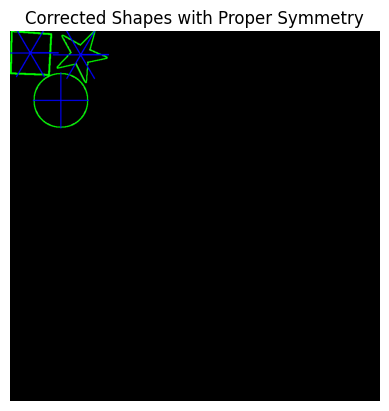

In [23]:
filename = input("Enter csv filename with extension")
# if filename ends with svg
if filename.endswith(".svg"):
    filename = filename.split(".")[0]
    print(filename)
    # convert svg to png
    svg2png(url=f"{filename}.svg",write_to=f"temp/{filename.split('/')[1]}.png")
    filename = f"temp/{filename}.png"
elif not filename.endswith(".png"):
    filename = f"{filename}.png"

image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

corrected_image = detect_shapes_and_draw_correct_lines(image)
plt.imshow(cv2.cvtColor(corrected_image, cv2.COLOR_BGR2RGB))
plt.title('Corrected Shapes with Proper Symmetry')
plt.axis('off')
plt.show()